# 12장 메트릭과 증강을 활용한 훈련 개선

딥러닝 프로젝트가 자리잡았지만 모델이 높은 점수를 얻고자 모든 샘플을 음성으로 판단하여 정확도로 평가하다보니 표면적으로 좋게 나온다. 이 장은 어떻게 측정하고 정량화하며 표현할지, 그리고 모델의 작업 수행을 어떻게 개선할지에 대해 설명한다. 

## 12.1 개선을 위한 상위 계획
추상적이지만 이번 장에서 배울 내용이 아래 그림에 있다고 한다.

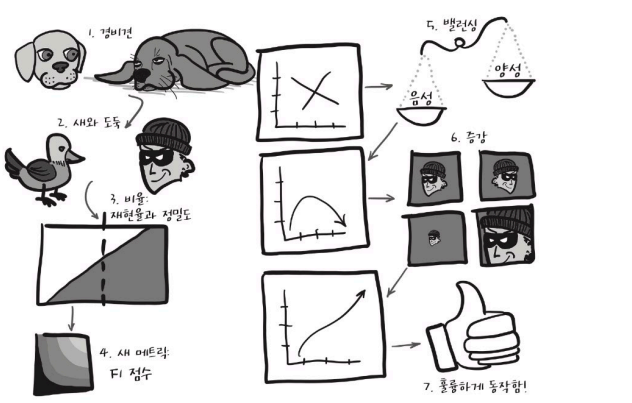

## 12.2 착한 개와 나쁜 녀석: 거짓 양성과 거짓 음성

개가 두 마리 있다고 생각해보자. 한 녀석은 무엇을 보든 다 짖고, 나머지 한 마리는 정확히 도둑을 봤을 때만 짖지만 그건 안타깝게도 안 깨어 있을 때 뿐이다. 앞 강아지는 심각한 거짓 양성을 가진 개다. 거짓 양성이란 관심사나 원하는 부류로 분류되는 일이 발생했지만 실제로는 아닌 경우다. 우리 모델 같은 경우는 결절이 아닌데 결절로 감지되어 있는 경우로 보면 된다.\
거짓 양성과 반대로 참 양성이 있다. 관심 항목을 잘 분류한 경우다.\
후자의 경우에는 거짓 음성을 가진 경우다. 거짓 음성이란 관심사가 아니거나 관심 분류가 아니라고 판단되는 일이 발생했지만 사실은 관심 대상인 경우다. 우리 경우에는 결절을 발견하지 못한 것이다.\
거짓 음성과 반대는 참 음성이다. 아이템이 관심 대상이 아닌 것을 잘 식별한 경우다.

## 12.3 긍정과 부정의 경우를 도식화하기

시각적으로 참/거짓 양성/음성을 표현하는 도식을 만들어보자

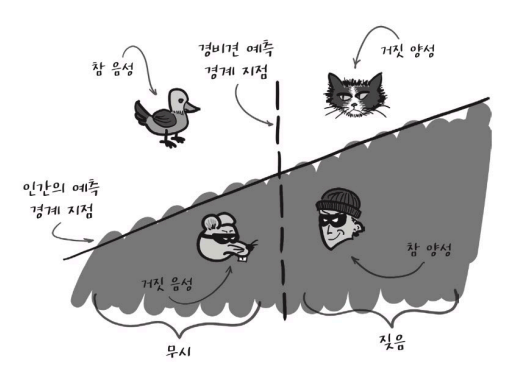

위 그림에는 두 가지 경계선이 있는데, 하나는 사람이 구분하는 선이고, 이는 훈련 샘플이나 검증 샘플에 있는 레이블로 보면 된다. 다른 하나는 어떤 사물에 대해 강아지가 짖을 경우인데, 이는 모델이 만들어내는 예측값에 해당한다. 

우리 모델은 이진분류이므로, 예측 경계란 단일 숫자로 출력된 값을 우리 분류의 경계값과 비교하는 것이라 생각해볼 수 있다. 따라서 분류 경계선을 완전한 수직으로 그렸다.

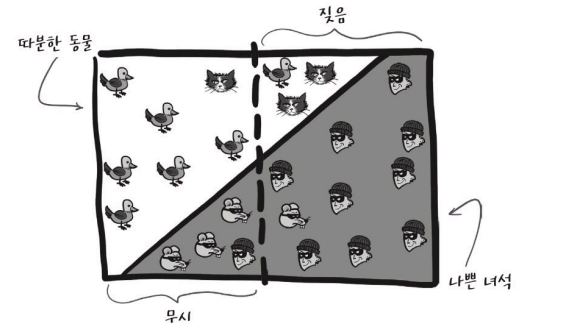

위 그림에서는 새와 도둑을 명확히 분류하는 대각선을 볼 수 있지만 우리 모델은 단지 x축 부분만 인지할 수 있다. 개의 입장에서는 언제 짖을지 말지에 대한 기준을 잡아야 한다. 짖을 가치가 있는 경계선을 수직으로 잡아야하므로 완벽한 기준은 불가능하다. 우리가 사용할 데이터는 차원이 높다. 모델의 역활은 각 이벤트 관련 특성을 위 사분면의 어딘가로 매핑하고, 수직선 하나로 양성과 음성을 분리하는 것이다. 이 작업을 모델의 마지막에 높인 nn.Linear가 담당한다. 우리가 하드코딩한 classificationThreshold_float=0.5가 수직선의 위치다. 실제로 데이터는 2차원으로 끝나지 않고, 백본 단계에서 차원이 올라가다가 다시 한 차원이 되어 각 샘플당 하나의 스칼라값이 된다. 여기에서 우리는 모델이 샘플에서 볼 수 없는 특징(성별, 폐에서 결절 후보 위치)을 나타내는 두 번쨰 차원을 사용한다. 위 그림에서 각 사분면 영역과 샘플은 모델의 성능을 논의할 때 필요한 값이다. 이 값을 사용해 좀 더 복잡한 매트릭을 만들어서 얼마나 객관적으로 잘하고 있는지를 판단할 수 있다.

### 12.3.1 아무나 보고 짖는 록시의 장점은 재현율

아무나 보고 짖는 첫 번쨰 강아지 이름을 록시라고 하자. 재현율(recall)은 주의할 이벤트는 단 하나도 놓치지 마라!라는 의미다. 재현율은 참양성과 거짓 음성의 합집합에 대한 양성의 비율이다.(TP/(TP+FP))재현율을 개선하려면 거짓 음성만 줄이면 된다. 

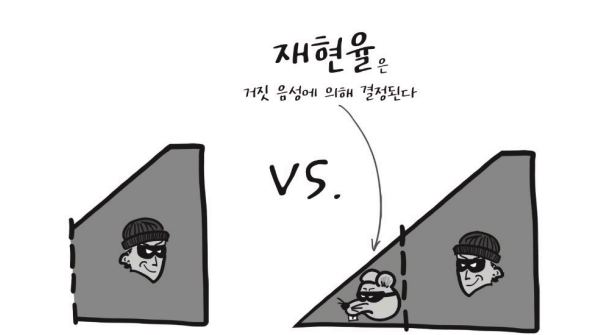

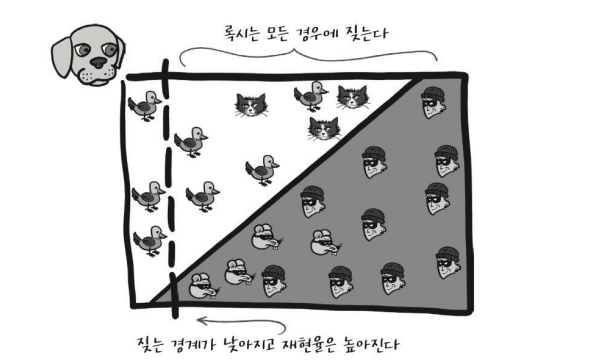

위 경우에서 록시의 재현율은 1.0에 가깝고 99%의 도둑에 대해 짖었다는 의미다. 그러나 거짓 양성에 대한 높은 비용도 감수해야 한다.

### 12.3.2 잠은 많아도 도둑은 잘 잡는 프레스톤의 특기는 정밀도

두 번쨰 강아지 이름을 프레스톤이라고 해보자. 정밀도(precision)은 기본적으로 확실한 것이 아니면 짖지 않기다. 정밀도를 높이려면 거짓 양성을 낮춰야 한다. 정밀도는 참 양성과 거짓 양성의 합집합에 대한 참 양성의 비율이다(TP/(TP+FP)). 

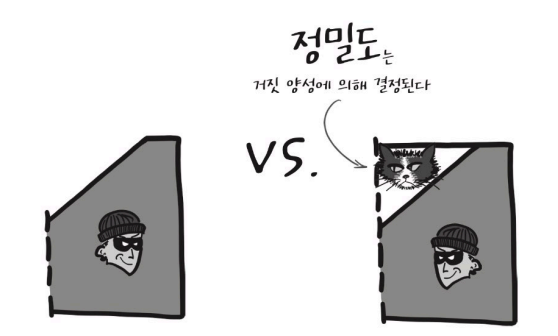

프레스톤은 분류 경계를 오른쪽 끝으로 밀어붙여서 관심 이벤트가 아닌 경우를 최대한 배제하고 이를 통해 매우 높은 정밀도를 달성한다. 록시와의 전략이랑은 상반된다. 비록 상당 수의 이벤트를 감지하지 못한 채 지나치긴 하지만, 정밀도를 기준으로는 성공적이라고 할 수 있다.

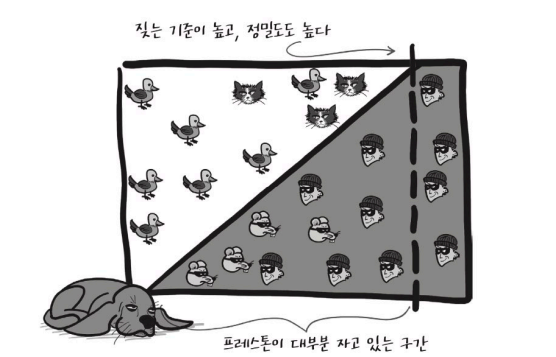

정밀도나 재현율이 모델을 평가하기 위한 단일 지표는 아니지만, 둘 다 훈련시에 사용할 만한 좋은 지표다.

### 12.3.3 logMetrics으로 정밀도와 재현율 구하기

만일 정밀도와 재현율 둘 중 하나가 0이 되면 모델이 안좋아지고 잇다는 얘기다. 손실값과 정확도 메트릭에 각 에포크마다 정밀도와 재현율을 출력하도록 추가하기 위해 logMetrics함수를 업데이트해보자.

In [ ]:
neg_count = int(negLabel_mask.sum())#음성
pos_count = int(posLabel_mask.sum())#양성
trueNeg_count = neg_correct = int((negLabel_mask & negPredMask).sum()) # 참 음성 개수 = 올바르게 레이블된 음성
truePos_count = pos_correct = int((posLabel_mask & posPredMask).sum()) # 참 양성 개수

falsePos_count = neg_count - neg_correct # 거짓 음성 개수
falseNeg_count = pos_count - pos_correct # 거짓 양성 개수

precision = metrics_dict['pr/precision'] = truePos_count / np.float32(truePos_count + falsePos_count)
recall = metrics_dict['pr/recall'] = truePos_count / np.float32(truePos_count + falseNeg_count)

### 12.3.4 궁극의 메트릭: F1 점수

재현율, 정밀도는 유용하지만 모델 평가를 위한 전부를 담고 있지는 않다. 이 둘을 합성한 일반적인 방법으로는 F1 점수를 사용한다. F1점수는 0과 1사이의 값이다. 0이 분류기 예측 성능이 없고, 1은 완벽하게 예측하는 상태다. logMetrics에서 이 값을 포함하도록 수정하자

In [ ]:
metrics_dict['pr/f1_score'] = 2*(precision*recall)/(precision + recall)

정밀도, 재현율, F1점수를 모두 포함하도록 로깅 출력ㅇ,ㄹ 개선해보자. 추가로 각 음성과 양성 샘플에 대해 전체 샘플 수와 정확하게 식별한 경우의 수도 포함한다.

In [ ]:
log.info(
("E{} {:8} {loss/all:4f} loss, "
 +"{correct/all:-5.1f}% correct, "
 + "{pr/precision:.4f} precision, "
 + "{pr/recall:.4f} precision, "
 + "{pr/f1_score:.4f} f1 score"
).format(
    epoch_ndx,
    mode_strm,
    **metrics_dict,
)
)

log.info(
("E{} {:8} {loss/neg:.4f} loss, "
 +"{correct/neg:-5.1f}% correct ( {neg_correct:} of {neg_count:})"
).format(
epoch_ndx,
mode_str+"_neg",
neg_correct=neg_correct,
neg_count=neg_count,
**metrics_dict,
)
)

### 12.3.5 새 메트릭으로 모델이 잘 동작하는지 확인하기

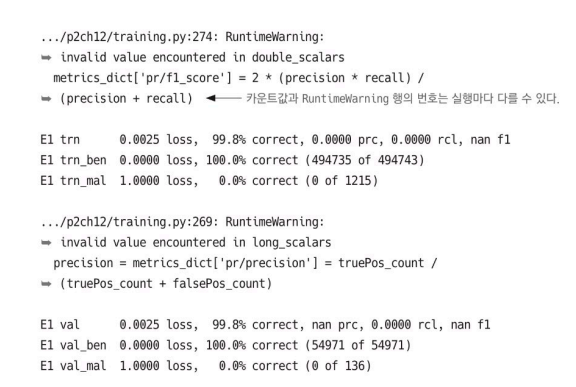

경고 메세지를 받은데다가 우리가 계산한 값에는 nan도 있다. 우리가 양성으로 분류된 케이스가 하나도 없으므로 정밀도와 재현율 모두 1이며, F1점수는 0으로 나눴기에 nan이 나온 것이다. 또한 검증셋을 보면 아무것도 양성으로 분류되지 않아서 truePos_count와 falsePos_count가 둘 다 0이다. precision 계산의 분모도 0이 된다. 

## 12.4 이상적인 데이터셋의 모습

앞서 분류 경계값을 설명하였을 때 경계값을 움직여 더 나은 결과를 얻는데는 한계가 있다는 점을 배웠다. 양성 클래스와 음성 클래스가 겹치는 구간이 많기 때문이다. 우리가 원하는 이미지는 아래와 같다

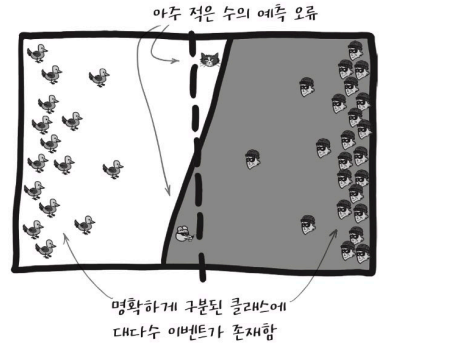

위를 보면 레이블 경계가 수직에 가깝다. 그리고 대부분의 샘플이 다이어그램의 양쪽 경계에 집중되어 있다. 일단 데이터를 보자. 우리 데이터는 꽤 불균형하다, 음성:양성이 400대1이다. 이런 조건이라면 실제 결절 샘플은 대량의 다른 데이터에 묻혀 잃어버렸다고 해도 과언이 아니다. 

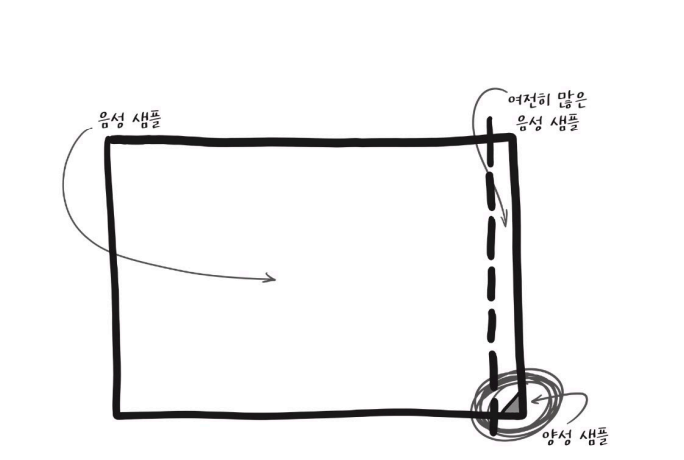

위처럼 우리는 데이터 밸런싱을 통해 불균형한 데이터를 균형을 맞춰줘야 한다. 

### 12.4.1 데이터를 실제보다 이상에 가깝게 만들기

최선은 더 많은 양성 샘플을 확보하는 것이다. 먼저 신경망의 가중치는 랜덤값으로 초기화되므로 같은 샘플에 대한 신경망의 출력값 또한 랜덤이고, 예측값과 레이블 결과의 차이에 따라 가중치를 조정한다. 약 50만개의 훈련 샘플에 대해 다음 그룹을 가정해보자
1. 25만개의 음성 샘플이 음성으로 예측되어 음성 예측에 관여하는 신경망의 가중치를 조금 변화시킨다.
2. 25만개의 음성 샘플이 양성으로 예측되어 음성 예측에 관여하는 신경망의 가중치를 크게 변화시킨다.
3. 500개의 양성 샘플이 음성으로 예측되어 양성 예측에 관여하는 신경망의 가중치를 크게 변화시킨다
4. 500개의 양성 샘플이 양성으로 예측되어 양성 예측에 관여하는 신경망의 가중치를 거의 변화시키지 않는다.

1, 4그룹의 크기는 훈련에 거의 영향을 주지 않으므로 중요하지 않다. 그러나 그룹 2와 3은 서로 반대로 당기며 대응하므로 신경망이 한 값만 출력하는 상태가 되는걸 예방하기에 충분하다. 또한 사실상 15개의 배치마다 겨우 한 개의 양성 샘플만 볼 수 있다. 15개의 훈련 배치 중 14개가 100% 음성이니, 모델의 가중치는 음성을 예측하도록 유도될 수 밖에 없다.\
이렇게 하지 말고 음성 샘플 수 만큼 양성 샘플을 늘려보자. 동시에 배치 안에서 음성과 양성 샘플을 골구로 섞는 것을 가정하자. 밸런싱은 음성과 양성 사이의 줄다리기를 안정화시키는 역활을 한다.\
다만 검증에서는 아무런 밸런싱 작업을 하지 않는다. 모델은 실세계에서 잘 동작하는 것이 목적이며 실세계는 불균형하다.

샘플러로 데이터셋 재구성하기\
DataLoader의 옵션 인자로 sampler=...가 있다. 이 옵션으로 데이터 원래의 순회 순서를 무시하고 데이터 차운 정보나 제한 등을 원하는대로 바꿀 수 있다. 다만 이렇게 변형을 가하면 데이터셋 캡슐화를 꺠드리는 단점이 있다. 원래는 Dataset API는 서브클래스가 __len__과 __getitem__만 제공되면 되었다. 그러나 현재는 샘플의 부류를 아는 APi가 필요하다.

LunaDataset을 직접 수정하여 훈련을 위한 양성과 음성 샘플이 1대1로 균형 잡히도록 만들자. 먼저 ratio_int를 생성자에 추가해준다. 다음 음성 리스트와 양성 리스트를 따로 작성한다.

In [ ]:
self.negative_list = [
    nt for nt in self.candidateInfo_list if not nt.isNodule_bool
]
self.positive_list = [
    nt for nt in self.candidateInfo_list if nt.isNodule_bool
]

def shuffleSamples(self): #매 에포크 시작점에서 이 메소드를 호출하여 ratio_int가 2라면 음성: 양성 2:1 비율로 샘플 순서를 랜덤하게 만든다
    if self.ratio_int:
        random.shuffle(self.negative_list)
        random.shuffle(self.pos_list)

ratio_int를 2로 놓아 음성: 양성 샘플을 2대1로 만든다면 모든 세 번쨰 인덱스는 양성이어야 한다.

In [ ]:
def __getitem__(self, ndx):
    if self.ratio_int:
        pos_ndx = ndx//(self.ratio_int+1)
        
        if ndx % (self.ratio_int+1): #나머지가 0이 아니면 음성
            neg_ndx = ndx - 1 - pos_ndx
            neg_ndx %= len(self.negative_list)
            candidateInfo_tup = self.negative_list[neg_ndx]
        else:
            pos_ndx %= len(self.pos_list)
            candidateInfo_tup = self.pos_list[pos_ndx]
    else:
        candidateInfotup = self.candidateInfo_list[ndx]

### 12.4.2 균형잡힌 LunaDataset으로 훈련시킨 결과의 차이

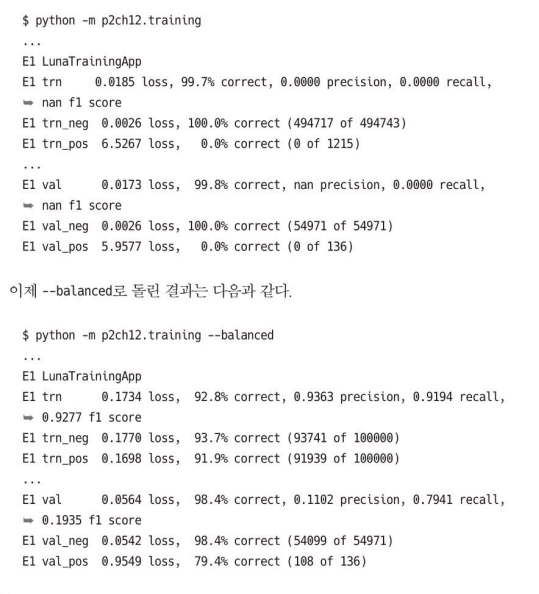

기존의 training과 --balanced 균형잡힌 데이터셋의 학습의 차이를 보자. 음성 샘플에 대해 5% 손해보는 대신 양성에 대해 86%의 정확도를 얻었다.

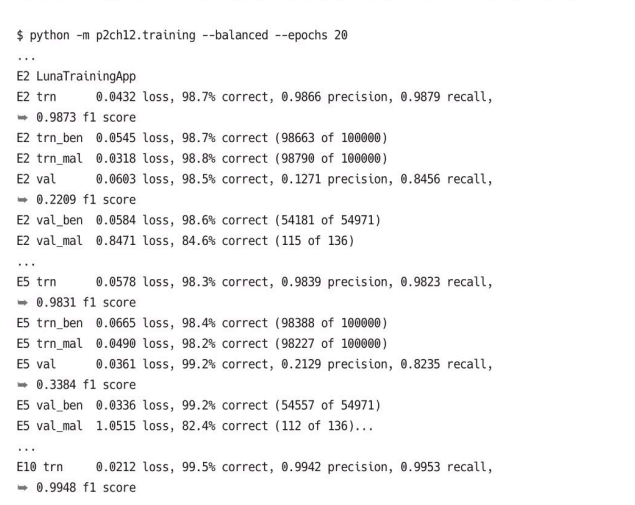
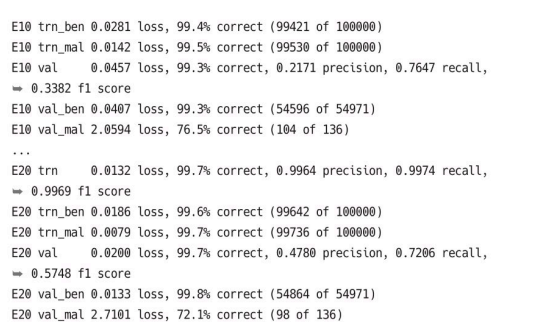

력을 내려보니 val_mal XX.X% correct 수치를 보면, 에포크 2에서 87.5가 되고 에포크 5에서는 92.6까지 넘어간 후 에포크 20에서는 86.8로 낮아진다. 훈련 샘플은 98.8 99.1로 정확하다. 과적합이 발생한 것이다.

### 12.4.3 과적합 증상 알아채기

양성 샘플에 대한 손실값 그래프를 보자. 

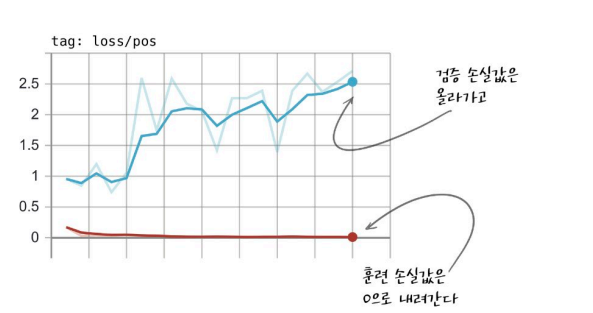

훈련 손실값은 0에 수렴하는 한편, 검증 손실값은 계속 증가하고 있다. 이런 상황에서는 모델이 더 이상 개선되지 않으므로 훈련 스크립트를 중단하는 편이 좋다. 매트릭을 살펴보면 양성 샘플의 수는 음성보다 400배 적으므로 모델은 학습을 통해 일반화된 원리를 배우는 대신 1215개의 샘플을 외워버리고 이 샘플에 해당하지 않는 것은 다 음성이라고 판단해버린다. 그래프를 보면 음성 손실 경향은 과적합을 보이지 않는다.

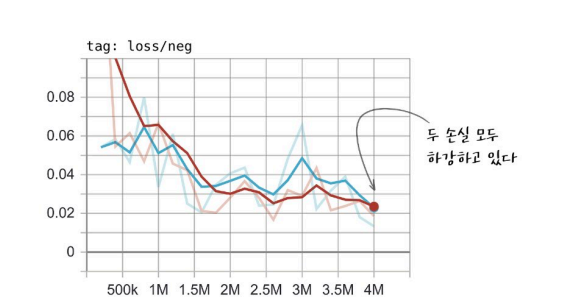

## 12.5 과적합 문제 다시 살펴보기

우리는 모델이 우리가 관심이 있어 하는 부류의 일반적인 특성을 데이터셋을 보고 배우게 하는 것이다. 모델이 어떤 특성을 배우기 시작하면 과적합이 발생한다.

## 12.6 데이터 증강으로 과적합 방지하기

개별 샘플에 대한 합성을 통해 원래보다 많은 새로운 데이터셋을 만들어 데이터셋을 증강시키고 훈련 효과를 높여보자. 

### 12.6.1 특별 데이터 증강 기술
5가지 특별한 데이터 증강 기술에 대해 알아보자\
1. 이미지를 위-아래 혹은 좌-우 혹은 앞-뒤로 반전한다
2. 이미지를 몇 복셀만큼 평행이동시킨다.
3. 이미지를 확대 또는 축소한다.
4. 머리-밭 축을 중심으로 이미지를 회전한다.
5. 이미지에 노이즈를 추가한다\
훈련 샘플 본연의 특징은 그대로 유지되어야 한다.

아핀 변환 행렬을 정의하고 파이토치의 affine_grid와 grid_sample을 함꼐 사용하여 후보 샘플을 다시 만든다.

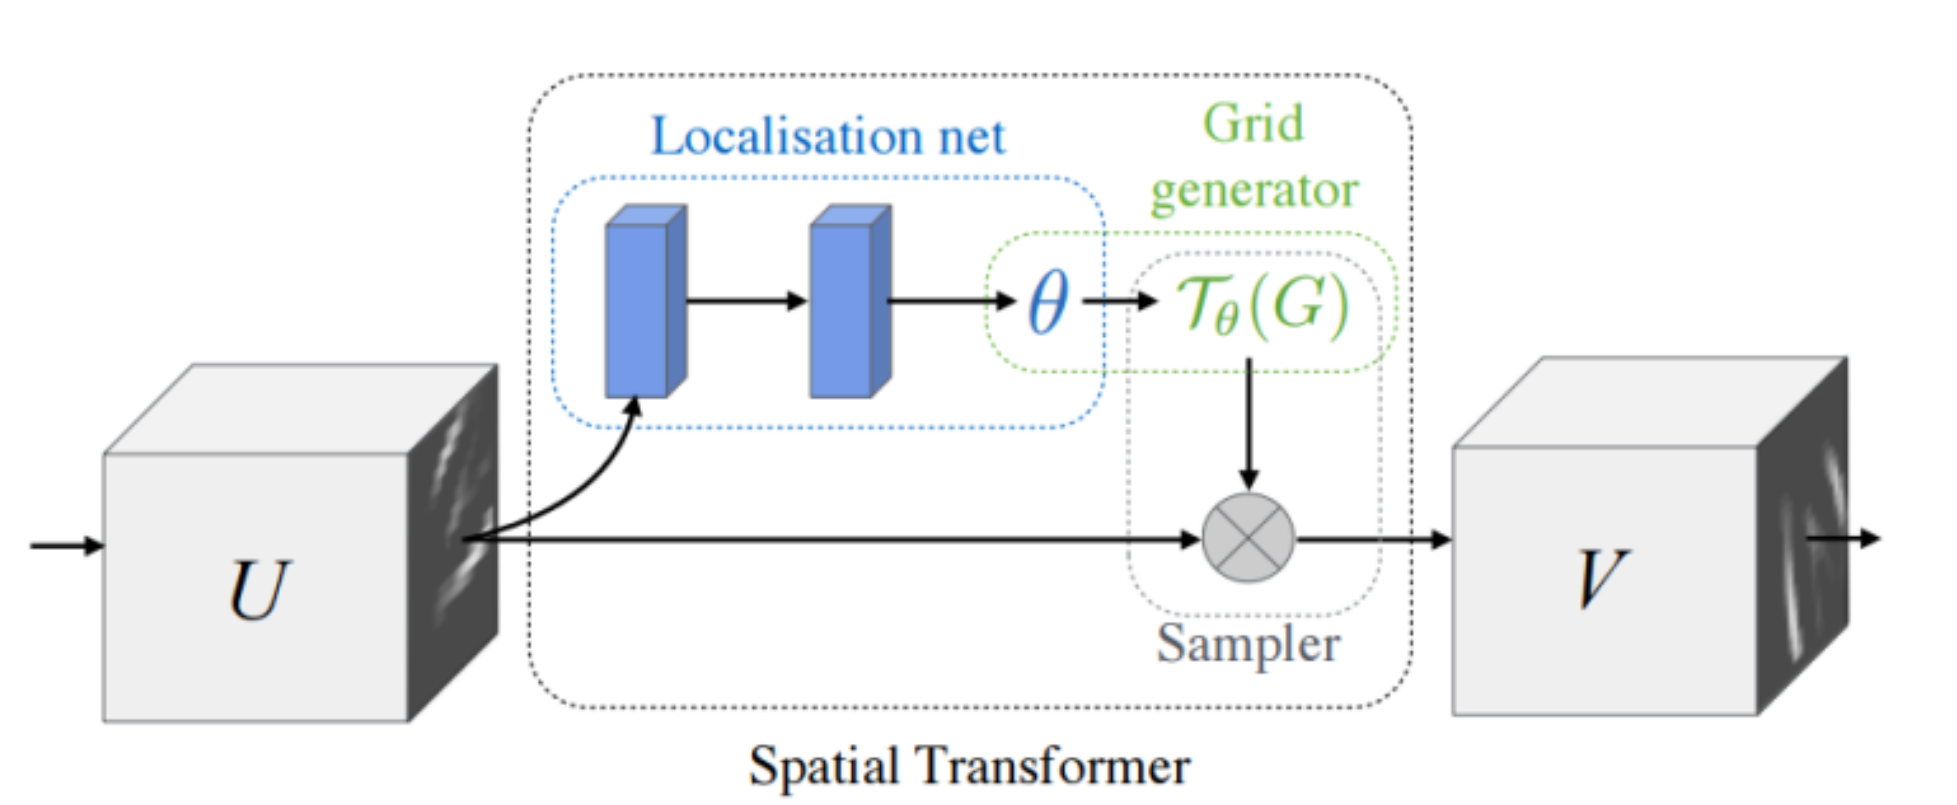

아핀 그리드는 컨볼루션이 scale, rotation, translation에 강해지도록 네트워크를 별도로 학습하여 입력 영상을 정규화하는 과정이다. 이러한 ST network는 CNN block 전후로 사용 가능하다. 

In [ ]:
def getCtAugmentedCandidate(augmentation_dict, series_uid, center_xyz, width_irc, use_cache=True):
    if use_cache: #캐시를 사용하면 getCt(series_uid)를 해줄 필요가 없다. 
        ct_chunk, center_irc = getCtRawCandidate(series_uid, center_xyz, width_irc)
    else:
        ct = getCt(series_uid)
        ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    ct_t = torch.tensor(ct_chunk).unsqueeze(0).unsqueeze(0).to(torch.float32)# 텐서로 변환

다음은 아핀 그리드와 샘플링 코드다

In [ ]:
affine_t = F.affine_grid(
            transform_t[:3].unsqueeze(0).to(torch.float32),
            ct_t.size(),
            align_corners=False,
        )

    augmented_chunk = F.grid_sample(
            ct_t,
            affine_t,
            padding_mode='border',
            align_corners=False,
        ).to('cpu')

#### 미러링
미러링은 픽셀값은 그대로 두고 이미지 오리엔테이션만 바꾼다. 좌-우 앞-뒤 방향은 종양의 성장과 강한 상관관계가 없지만 위 아래는 중력 방향과 일치하므로 차이가 있을 수 있다. 책에서는 없다고 가정한다.

In [ ]:
for i in range(3):
        if 'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1

미러링하기 위해서는 변환 행렬의 관련 요소에 -1을 곱하기만 하면 된다. 

#### 랜덤 크기만큼 평행이동 시키기 (오프셋)
컨볼루션은 평행이동에 독립적으므로 평행이동을 해도 잘 분류해 내겠지만 성능에 차이를 낼 수 없다. 오프셋이 복셀 단위의 정수여야 하므로, 삼중 선형 보간법을 사용하여 약간의 흐림 처리가 들어가는 형태로 데이터는 다시 샘플링된다.

In [ ]:
for i in range(3):
    if 'offset' in augmentation_dict:
            offset_float = augmentation_dict['offset']
            random_float = (random.random() * 2 - 1)
            transform_t[i,3] = offset_float * random_float

#### 회전
우리가 만든 CT 단면은 (32, 48, 48)이므로 복셀은 정육면체가 아니다. 가능한 방법으로는 Z축을 다른 두 축과 동일하게 해상도를 조절하게끔 하는 것이지만, 데이터 신뢰도가 떨어지므로 X-Y축만 회전을 한다.

In [ ]:
if 'rotate' in augmentation_dict:
        angle_rad = random.random() * math.pi * 2 #랜덤 회전 각도
        s = math.sin(angle_rad)
        c = math.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

        transform_t @= rotation_t

#### 노이즈
노이즈는 단순히 뒤집거나 회전하는 식이 아니라 실제로 샘플을 어느 정도 망가뜨린다. 떄문에 노이즈를 너무 많이 넣으면 아예 분류하지 못하게 될 수도 있다.

In [ ]:
if 'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t

#### 증강된 후보 살펴보기

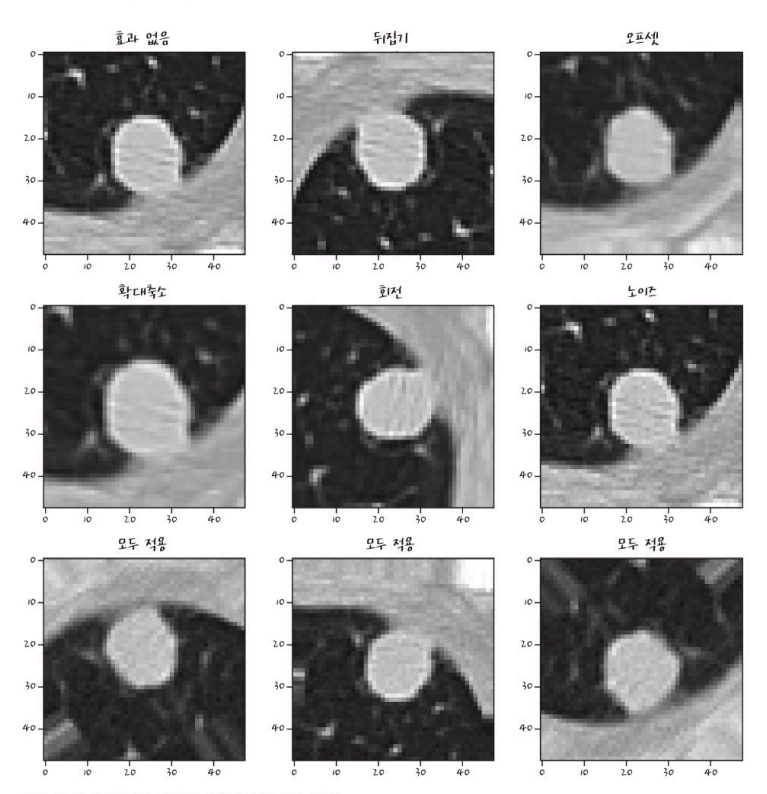

### 12.6.2 데이터 증강 효과 확인하기
각 증강 타입을 켜거나 끄기 위해 augmentation_dict 생성 부분을 명령행에 노출할 필요가 있다. value로 준 값은 경험에서 나온 것이며 더 나은 값이 존재할 수 있다

In [ ]:
self.augmentation_dict = {}
        if self.cli_args.augmented or self.cli_args.augment_flip:
            self.augmentation_dict['flip'] = True
        if self.cli_args.augmented or self.cli_args.augment_offset:
            self.augmentation_dict['offset'] = 0.1
        if self.cli_args.augmented or self.cli_args.augment_scale:
            self.augmentation_dict['scale'] = 0.2
        if self.cli_args.augmented or self.cli_args.augment_rotate:
            self.augmentation_dict['rotate'] = True
        if self.cli_args.augmented or self.cli_args.augment_noise:
            self.augmentation_dict['noise'] = 25.0

Augmentation을 해준 샘플들을 전부 학습 시켰다.

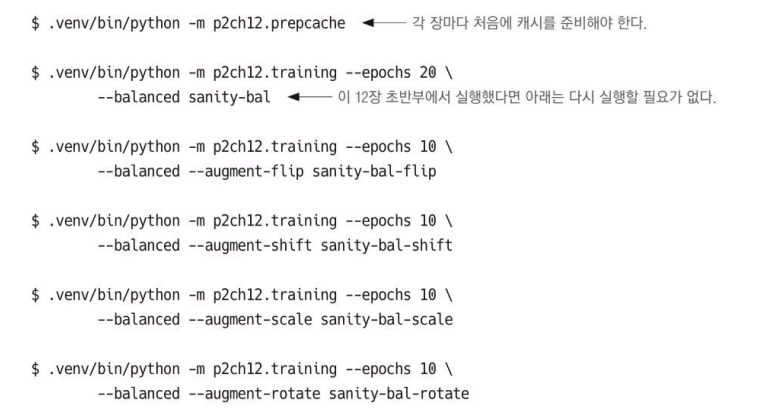
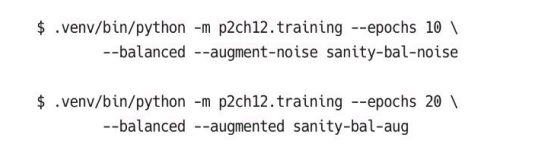

실행을 하며 텐서보드를 실행해보자.

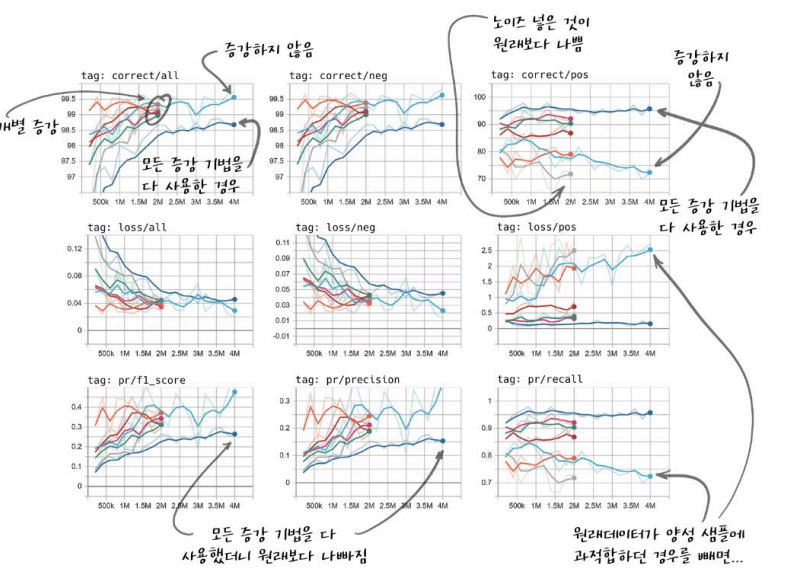

correct/all 그래프를 보면 개별 증강 유형에 대한 그래프가 뒤죽박죽 섞여 있는데, 증강 타입을 섞었을 때가 각각의 합보다 효과가 크다는 뜻이다. 그러나 모든 증강 기법을 다 사용한 경우 오답률이 높아진다. 하지만 correct/pos를 보면 모든 증강 기법을 사용한 경우가 훨씬 낫다. 모든 증강을 사용항 모델의 재현율은 훌륭하다. 노이즈를 적용한 모델은 원래 모델보다 결절을 식별하는데 성능이 떨어진다. 노이즈는 분류를 어렵게 하는 것이므로 이해가 된다. 회전 증강을 사용한 모델이 재현율과 정밀도 면에서 전체 증강을 사용한 모델만큼 좋다. 우리 모델은 높은 재현율을 요구하므로 모든 증강 기법을 다 사용한 모델을 사용한다.